# Unsupervised Stacked AutoEncoder - Convolutional Layers

In [1]:
from PIL import Image
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
import seaborn as sns

2023-12-05 21:23:14.736733: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_ds = 'train/'
len(os.listdir(train_ds))

71056

### Base dataset

In [3]:
train = []
files = [file for file in os.listdir(train_ds) if '.jpg' in file or '.jpeg' in file]
for file in files[:25000]:
  try:
    img = Image.open(train_ds + f"{file}")
    if np.asarray(img).shape == (200, 200, 3):
      train.append(np.asarray(img))
  except Exception as e:
    print(e)

In [4]:
train = np.array(train)
train.shape

(24880, 200, 200, 3)

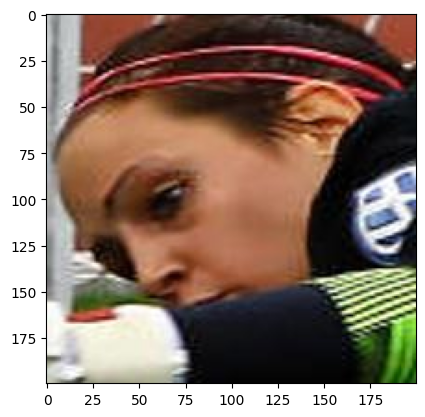

In [5]:
plt.imshow(train[0])

In [6]:
train = train.astype('float32') / 255.0

In [7]:
validation = train[int(len(train) * 0.8):]
train = train[:int(len(train) * 0.8)]
print(len(train))

19904


### Base Training

In [11]:
tf.random.set_seed(42)
np.random.seed(42)

encoder = keras.models.Sequential([
    keras.layers.Rescaling(1.0/255, input_shape=(200, 200, 3)),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size = 1),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(128, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D()
])
decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="SAME", activation="selu",
                                 input_shape=[50, 50, 128]),
    keras.layers.Conv2DTranspose(64, kernel_size=3, strides=1, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=1, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=1, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=1, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(3, kernel_size=3, strides=2, padding="same", activation="sigmoid",
                        ),
    keras.layers.Reshape([200, 200, 3])
])

In [3]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [13]:
autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(loss = 'binary_crossentropy',
                    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
                    metrics = rounded_accuracy)

In [14]:
autoencoder.fit(train, train, validation_data = [validation, validation],
                epochs = 5, batch_size = 64)

Epoch 1/5


2023-12-05 18:17:17.409756: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2023-12-05 18:17:19.775154: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb69e26a0b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-05 18:17:19.775202: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2023-12-05 18:17:19.775207: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2023-12-05 18:17:19.775212: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2023-12-05 18:17:19.775216: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (3): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2023-12-05 18:17:19.845660: I tensorflow/compiler/mlir/tensorflow/utils/dump_

311/311 [==============================] - 49s 128ms/step - loss: 0.5432 - rounded_accuracy: 0.8933 - val_loss: 0.5215 - val_rounded_accuracy: 0.9291
Epoch 2/5
311/311 [==============================] - 31s 99ms/step - loss: 0.5145 - rounded_accuracy: 0.9469 - val_loss: 0.5100 - val_rounded_accuracy: 0.9545
Epoch 3/5
311/311 [==============================] - 30s 97ms/step - loss: 0.5099 - rounded_accuracy: 0.9559 - val_loss: 0.5085 - val_rounded_accuracy: 0.9576
Epoch 4/5
311/311 [==============================] - 30s 97ms/step - loss: 0.5086 - rounded_accuracy: 0.9591 - val_loss: 0.5075 - val_rounded_accuracy: 0.9603
Epoch 5/5
311/311 [==============================] - 30s 97ms/step - loss: 0.5077 - rounded_accuracy: 0.9612 - val_loss: 0.5066 - val_rounded_accuracy: 0.9631


In [15]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def show_reconstructions(model, images=train, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

1/1 [==============================] - 0s 348ms/step


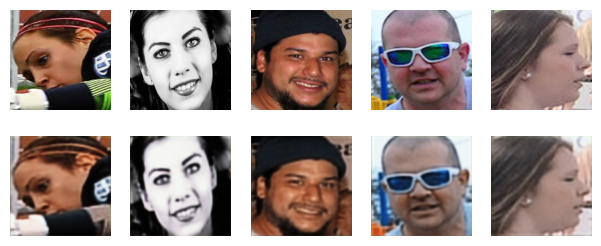

In [16]:
show_reconstructions(autoencoder)

In [17]:
embeddings = encoder.predict(train)

622/622 [==============================] - 7s 10ms/step


### Performing KMeans clustering, mapping each emotion to a cluster and visualizing using T-SNE

In [19]:
from sklearn.manifold import TSNE

X_valid_compressed = encoder.predict(train)
X_valid_compressed = X_valid_compressed.reshape(-1, 50*50*128)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

622/622 [==============================] - 6s 10ms/step


In [20]:
emotions = {
    0:'neutral', 
    1:'happy', 
    2:'anger', 
    3:'fear', 
    4:'sad', 
    5:'surprise', 
    6:'disgust', 
    7:'contempt'
           }

emotion_labels = list(emotions.values())
emotion_clusters = emotions.keys()

kmeans = KMeans(n_clusters = len(emotion_labels)).fit(embeddings.reshape(-1, 50*50*128))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Using output below, change emotions dictionary to map each index to most appropriate cluster

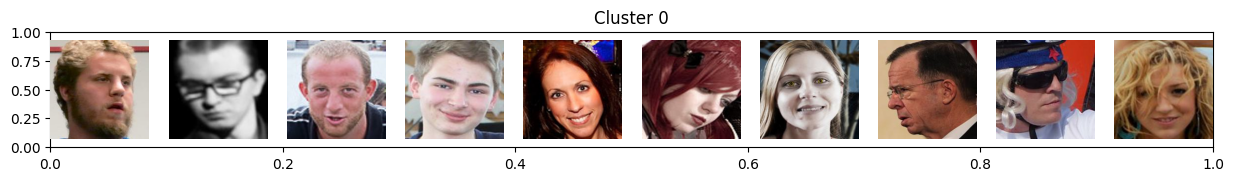

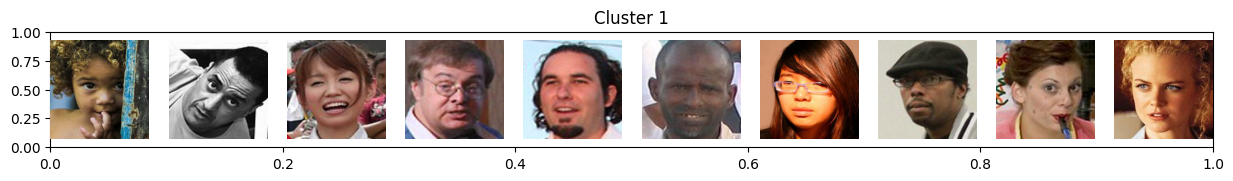

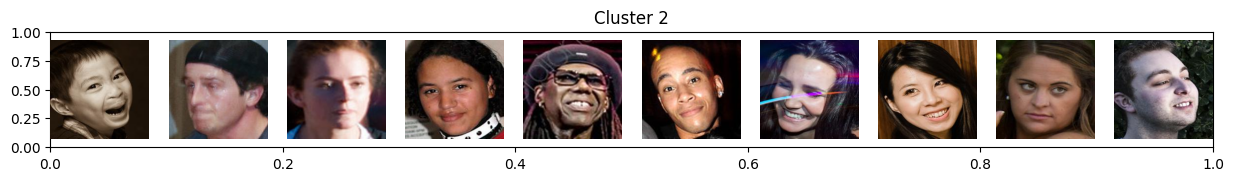

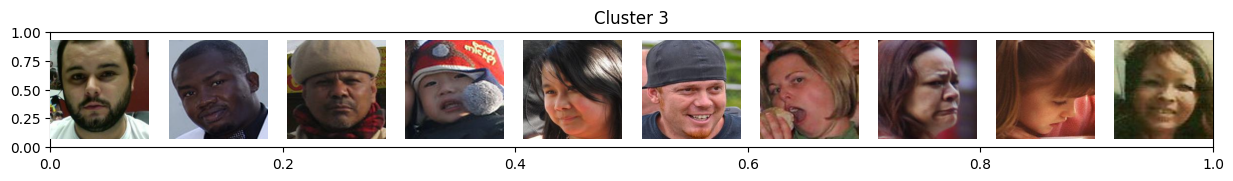

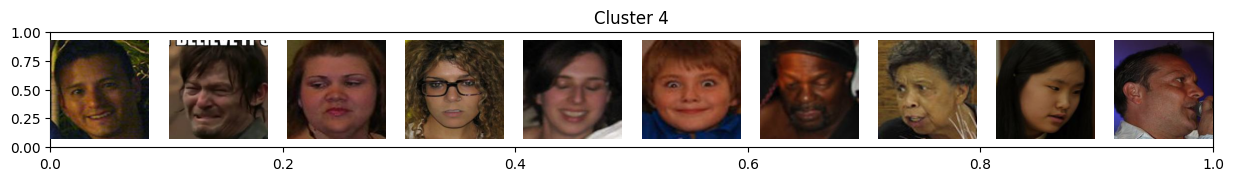

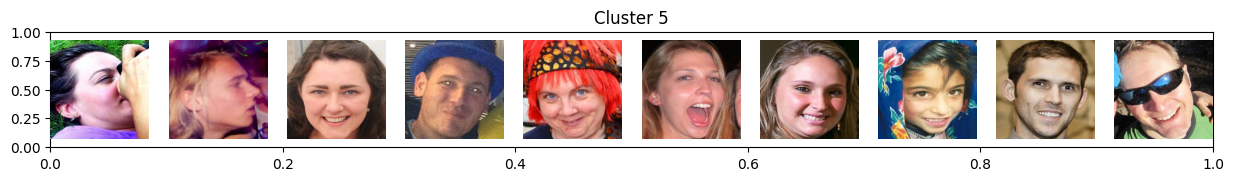

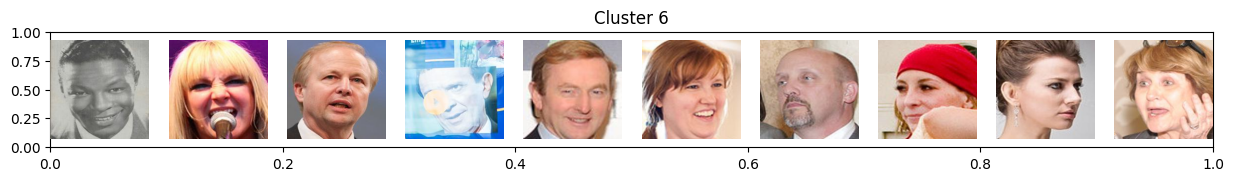

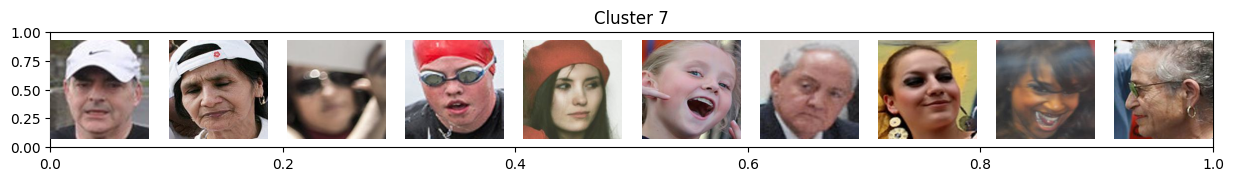

In [21]:
# Get cluster labels
cluster_labels = kmeans.labels_

# Number of clusters
num_clusters = kmeans.n_clusters

# Number of images to display per cluster
num_images_per_cluster = 10

# Iterate over each cluster
for cluster in range(num_clusters):
    # Find indices of data points in the current cluster
    cluster_indices = np.where(cluster_labels == cluster)[0]
    
    # Select 10 random indices from the current cluster (or use a different strategy to select)
    selected_indices = np.random.choice(cluster_indices, size=min(num_images_per_cluster, len(cluster_indices)), replace=False)
    
    # Display images from the current cluster
    plt.figure(figsize=(15, 1.5))
    plt.title(f'Cluster {cluster}')
    for i, index in enumerate(selected_indices):
        plt.subplot(1, num_images_per_cluster, i + 1)
        plt.imshow(train[index].reshape((200, 200, 3)))  # Assuming images are 3D, adjust if needed
        plt.axis('off')
    plt.show()

Using the images from the clusters above, assign the best aligning emotion to each cluster in the dictionary below:

In [23]:
emotions = {
    0:'neutral',
    1:'surprise',
    2:'contempt',
    3:'fear',
    4:'anger',
    5:'happy',
    6:'sad',
    7:'disgust',
}

### Load and Evaluate Emotions using AffectNet Data

Predicting emotion:  neutral
161/161 [==============================] - 2s 11ms/step
0.0 %
Predicting emotion:  happy
158/158 [==============================] - 2s 14ms/step
17.0 %
Predicting emotion:  anger
101/101 [==============================] - 2s 16ms/step
5.0 %
Predicting emotion:  fear
100/100 [==============================] - 1s 13ms/step
7.000000000000001 %
Predicting emotion:  sad
97/97 [==============================] - 2s 16ms/step
19.0 %
Predicting emotion:  surprise
127/127 [==============================] - 2s 12ms/step
8.0 %
Predicting emotion:  disgust
78/78 [==============================] - 1s 16ms/step
18.0 %
Predicting emotion:  contempt
90/90 [==============================] - 2s 18ms/step
21.0 %
Overall test accuracy: 0.10980648715653192


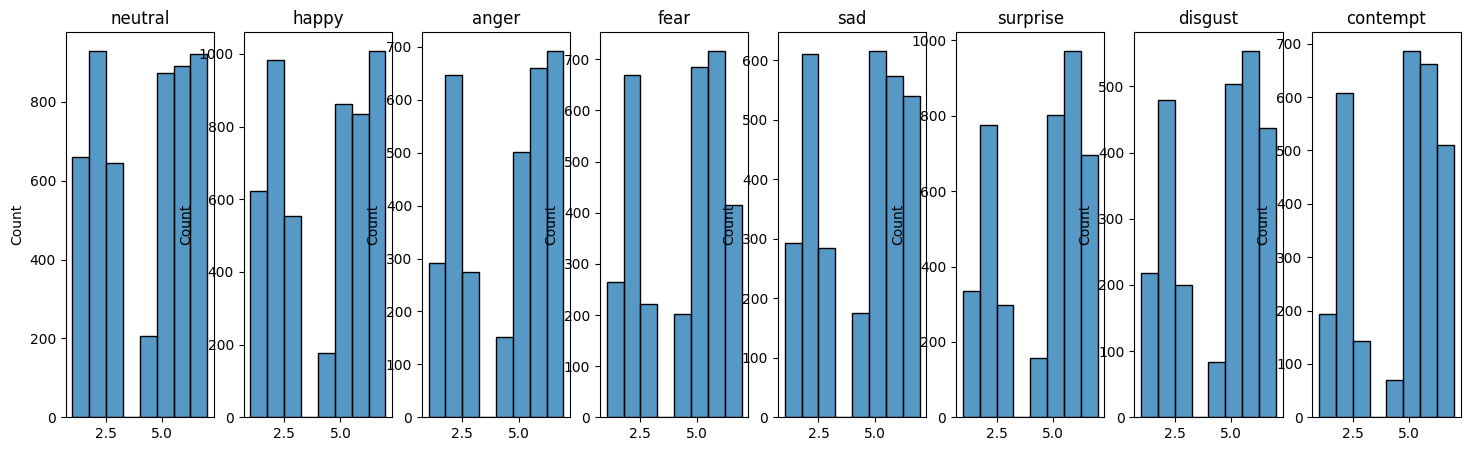

In [24]:
fig, axes = plt.subplots(1, len(emotion_labels), figsize=(18, 5))

h_index = 0

overall_correct = 0
overall_data_len = 0
for emotion in emotion_labels:
    print("Predicting emotion: ", emotion)
    test = []
    
    test_ds = 'affectnet/' + emotion + '/'
    test_files = [file for file in os.listdir(test_ds) if '.jpg' in file or '.png' in file]
    
    for file in test_files:
        try:
            #image = np.asarray((Image.open(test_ds + f"{file}")).convert('L').resize((200, 200)))
            image = np.asarray((Image.open(test_ds + f"{file}")).resize((200, 200)))
            test.append(image)
            overall_data_len += 1
        except Exception as e:
            print(e)
    
    test = np.array(test)
    test = test.astype('float32') / 255.0
    test_embeddings = encoder.predict(test)
    predictions = kmeans.predict(test_embeddings.reshape(-1, 50*50*128))
    
    sns.histplot(ax=axes[h_index], data=predictions, bins=len(emotion_labels)).set_title(emotion)
    
    correct = 0
    
    for key, value in emotions.items():
        if value == emotion:
            emotion_key = key
 
    for i in predictions:
        if i == emotion_key:
            correct += 1
            overall_correct += 1

    print(round(correct/len(predictions), 2)*100, '%')
    
    h_index += 1
    
print(f"Overall test accuracy: {overall_correct/overall_data_len}")

In [25]:
mapped_emotions = [emotion_labels[label] for label in kmeans.labels_]

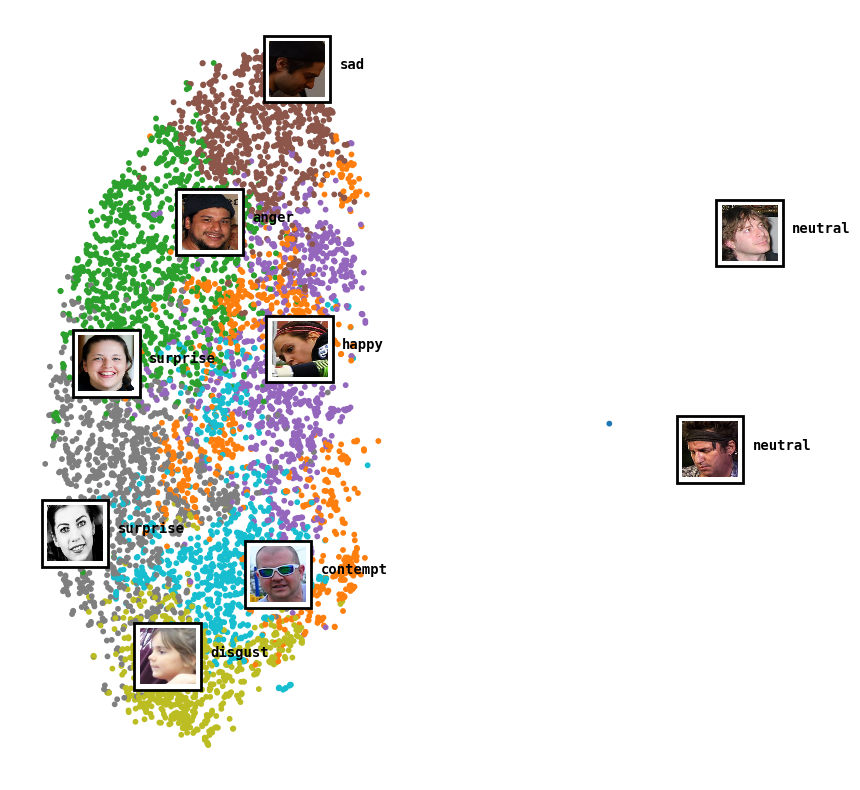

In [27]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=7)
mpl.rc('xtick', labelsize=6)
mpl.rc('ytick', labelsize=6)

plt.figure(figsize=(10, 10))
font_properties = {'family': 'monospace', 'color': 'black', 'weight': 'bold', 'size': 10}

cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c = kmeans.predict(embeddings.reshape(-1, 50*50*128)), s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(train[index], zoom=0.2, cmap="binary"),
            position, bboxprops={"lw": 2})
        plt.gca().add_artist(imagebox)
        plt.text(position[0] + 0.05, position[1], mapped_emotions[index], fontdict=font_properties)
plt.axis("off")
plt.show()

### Grayscale dataset

In [5]:
train = []
files = [file for file in os.listdir(train_ds) if '.jpg' in file or '.jpeg' in file]
for file in files[:25000]:
  try:
    img = Image.open(train_ds + f"{file}").convert('L')
    if np.asarray(img).shape == (200, 200):
      train.append(np.asarray(img))
  except Exception as e:
    print(e)

In [6]:
train = np.array(train)
train.shape

(25000, 200, 200)

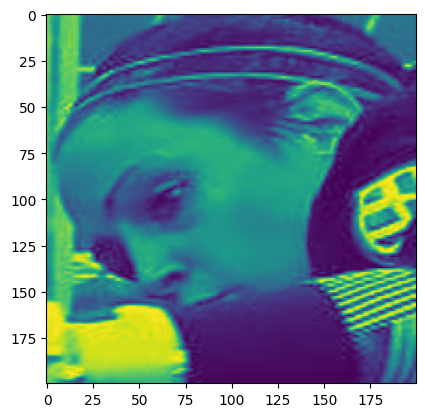

In [7]:
plt.imshow(train[0])

In [8]:
train = train.astype('float32') / 255.0

In [9]:
validation = train[int(len(train) * 0.8):]
train = train[:int(len(train) * 0.8)]

print(len(train))

20000


### Grayscale training

In [10]:
tf.random.set_seed(42)
np.random.seed(42)

encoder = keras.models.Sequential([
    keras.layers.Rescaling(1.0/255, input_shape=(200, 200, 1)),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size = 1),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(128, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D()
])
decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="SAME", activation="selu",
                                 input_shape=[50, 50, 128]),
    keras.layers.Conv2DTranspose(64, kernel_size=3, strides=1, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=1, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=1, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=1, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="same", activation="sigmoid",
                        ),
    keras.layers.Reshape([200, 200, 1])
])

2023-12-05 19:42:35.421846: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78823 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2023-12-05 19:42:35.426314: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78823 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0f:00.0, compute capability: 8.0
2023-12-05 19:42:35.428111: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 78823 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:47:00.0, compute capability: 8.0
2023-12-05 19:42:35.429861: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 78823 MB memory:  -> device: 3, name: NVIDIA A100-SXM4-80GB, pci bu

In [13]:
autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(loss = 'binary_crossentropy',
                    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), #tried Adam and lr = 0.0001 -> 89%
                    metrics = rounded_accuracy)

In [15]:
autoencoder.fit(train, train, validation_data = [validation, validation],
                epochs = 5, batch_size = 64)

Epoch 1/5
313/313 [==============================] - 43s 120ms/step - loss: 0.5465 - rounded_accuracy: 0.9277 - val_loss: 0.5315 - val_rounded_accuracy: 0.9494
Epoch 2/5
313/313 [==============================] - 28s 90ms/step - loss: 0.5296 - rounded_accuracy: 0.9606 - val_loss: 0.5286 - val_rounded_accuracy: 0.9625
Epoch 3/5
313/313 [==============================] - 28s 89ms/step - loss: 0.5282 - rounded_accuracy: 0.9659 - val_loss: 0.5273 - val_rounded_accuracy: 0.9693
Epoch 4/5
313/313 [==============================] - 28s 89ms/step - loss: 0.5271 - rounded_accuracy: 0.9696 - val_loss: 0.5268 - val_rounded_accuracy: 0.9697
Epoch 5/5
313/313 [==============================] - 28s 89ms/step - loss: 0.5264 - rounded_accuracy: 0.9728 - val_loss: 0.5258 - val_rounded_accuracy: 0.9756


In [16]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def show_reconstructions(model, images=train, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

1/1 [==============================] - 0s 346ms/step


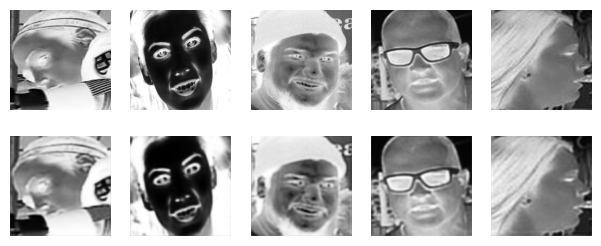

In [17]:
show_reconstructions(autoencoder)

In [18]:
embeddings = encoder.predict(train)

625/625 [==============================] - 7s 9ms/step


In [19]:
embeddings.shape

(20000, 50, 50, 128)

### Performing KMeans clustering, mapping each emotion to a cluster and visualizing using T-SNE (Grayscale)

In [20]:
from sklearn.manifold import TSNE

X_valid_compressed = encoder.predict(train)
tsne = TSNE()
X_valid_compressed = X_valid_compressed.reshape(-1, 50*50*128)
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

625/625 [==============================] - 6s 9ms/step


In [21]:
emotions = {
    0:'neutral', 
    1:'happy', 
    2:'anger', 
    3:'fear', 
    4:'sad', 
    5:'surprise', 
    6:'disgust', 
    7:'contempt'
            }

emotion_labels = list(emotions.values())
emotion_clusters = emotions.keys()

kmeans = KMeans(n_clusters = len(emotion_labels)).fit(embeddings.reshape(-1, 50*50*128))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


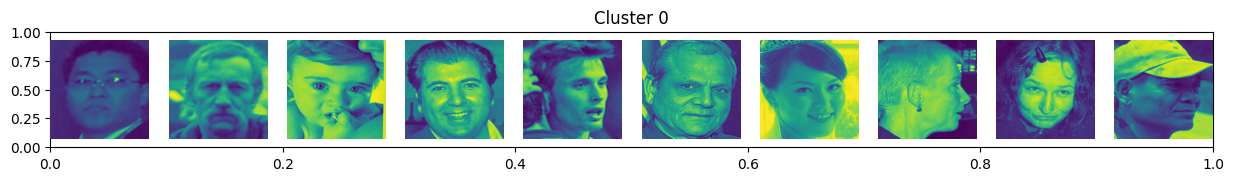

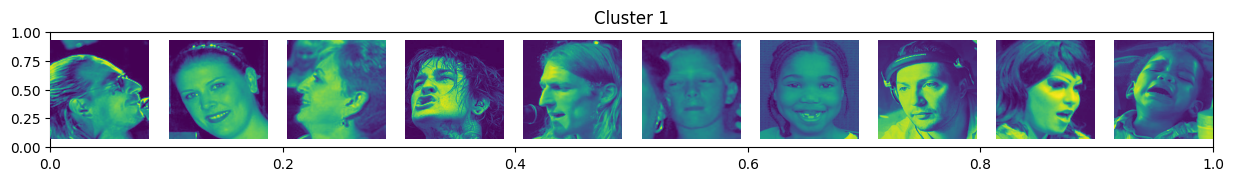

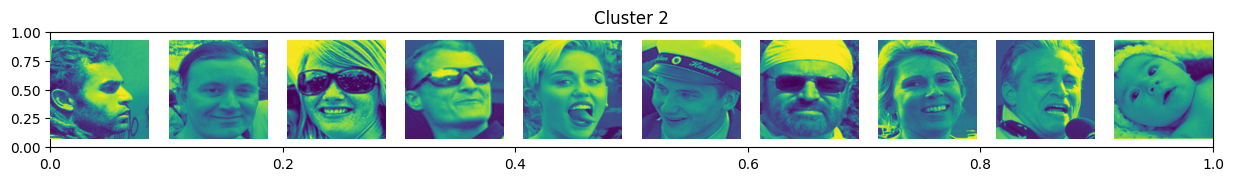

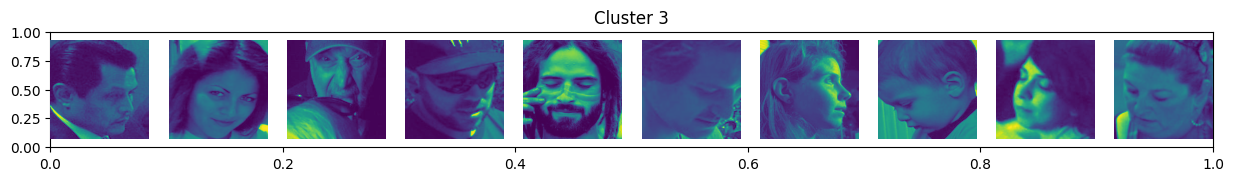

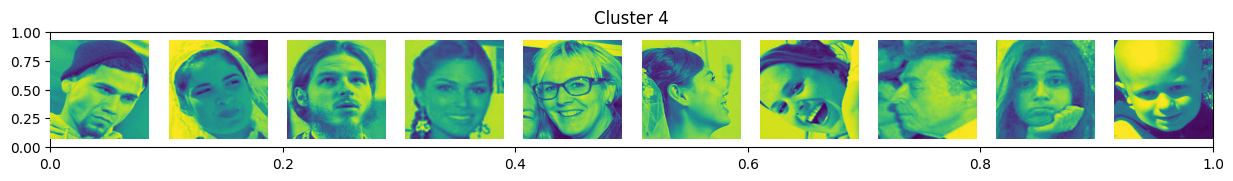

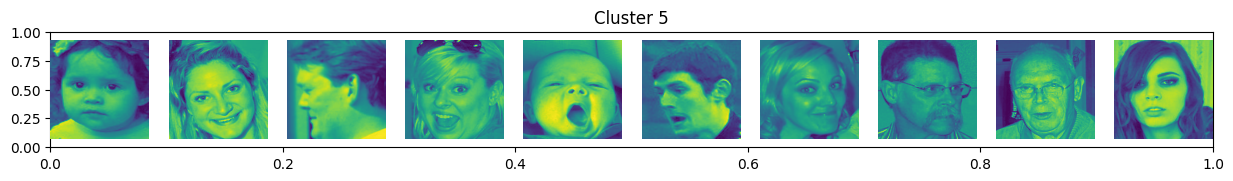

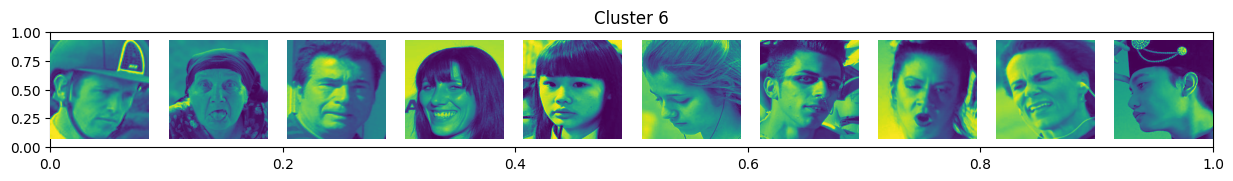

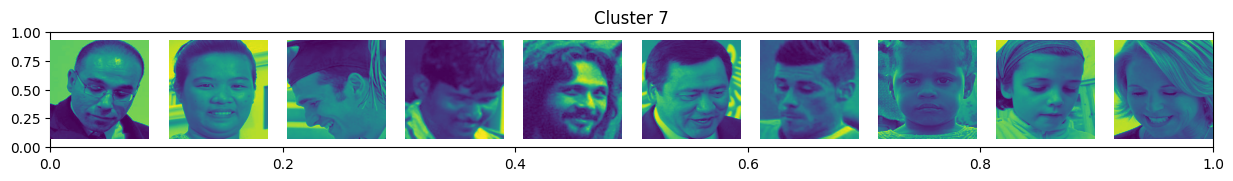

In [22]:
# Get cluster labels
cluster_labels = kmeans.labels_

# Number of clusters
num_clusters = kmeans.n_clusters

# Number of images to display per cluster
num_images_per_cluster = 10

# Iterate over each cluster
for cluster in range(num_clusters):
    # Find indices of data points in the current cluster
    cluster_indices = np.where(cluster_labels == cluster)[0]
    
    # Select 10 random indices from the current cluster (or use a different strategy to select)
    selected_indices = np.random.choice(cluster_indices, size=min(num_images_per_cluster, len(cluster_indices)), replace=False)
    
    # Display images from the current cluster
    plt.figure(figsize=(15, 1.5))
    plt.title(f'Cluster {cluster}')
    for i, index in enumerate(selected_indices):
        plt.subplot(1, num_images_per_cluster, i + 1)
        plt.imshow(train[index].reshape((200, 200)))  # Assuming images are 3D, adjust if needed
        plt.axis('off')
    plt.show()

Using the images from the clusters above, assign the best aligning emotion to each cluster in the dictionary below:

In [23]:
emotions = {
    0:'disgust',
    1:'surprised',
    2:'happy',
    3:'sad',
    4:'anger',
    5:'fear',
    6:'contempt',
    7:'neutral'
}

### Load and Evaluate Emotions using AffectNet Data (Grayscale)

Predicting emotion:  neutral
161/161 [==============================] - 2s 11ms/step
13.0 %
Predicting emotion:  happy
158/158 [==============================] - 2s 14ms/step
19.0 %
Predicting emotion:  anger
101/101 [==============================] - 2s 15ms/step
20.0 %
Predicting emotion:  fear
100/100 [==============================] - 1s 12ms/step
22.0 %
Predicting emotion:  sad
97/97 [==============================] - 2s 16ms/step
6.0 %
Predicting emotion:  surprise
127/127 [==============================] - 1s 11ms/step
4.0 %
Predicting emotion:  disgust
78/78 [==============================] - 1s 15ms/step
0.0 %
Predicting emotion:  contempt
90/90 [==============================] - 2s 18ms/step
8.0 %
Overall test accuracy: 0.12165140141863508


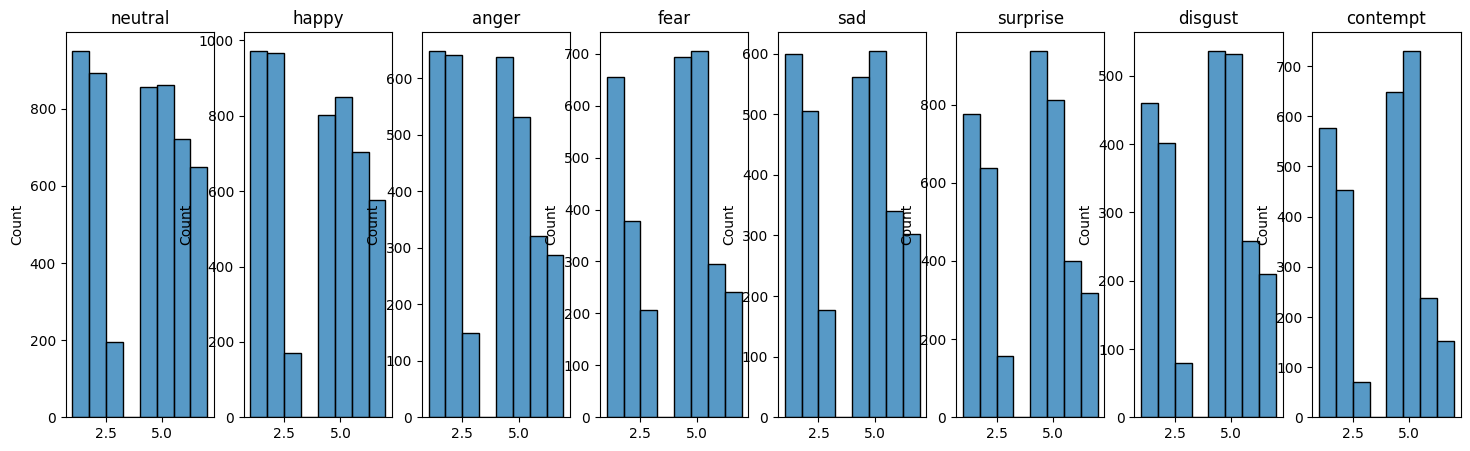

In [24]:
fig, axes = plt.subplots(1, len(emotion_labels), figsize=(18, 5))

h_index = 0

overall_correct = 0
overall_data_len = 0
for emotion in emotion_labels:
    print("Predicting emotion: ", emotion)
    test = []
    
    test_ds = 'affectnet/' + emotion + '/'
    test_files = [file for file in os.listdir(test_ds) if '.jpg' in file or '.png' in file]
    
    for file in test_files:
        try:
            image = np.asarray((Image.open(test_ds + f"{file}")).convert('L').resize((200, 200)))
#             image = np.asarray((Image.open(test_ds + f"{file}")).resize((200, 200)))
            test.append(image)
            overall_data_len += 1
        except Exception as e:
            print(e)
    
    test = np.array(test)
    test = test.astype('float32') / 255.0
    test_embeddings = encoder.predict(test)
    predictions = kmeans.predict(test_embeddings.reshape(-1, 50*50*128))
    
    sns.histplot(ax=axes[h_index], data=predictions, bins=len(emotion_labels)).set_title(emotion)
    
    correct = 0

    for key, value in emotions.items():
        if value == emotion:
            emotion_key = key
 
    for i in predictions:
        if i == emotion_key:
            correct += 1
            overall_correct += 1

    print(round(correct/len(predictions), 2)*100, '%')
    
    h_index += 1
    
print(f"Overall test accuracy: {overall_correct/overall_data_len}")

In [25]:
mapped_emotions = [emotion_labels[label] for label in kmeans.labels_]

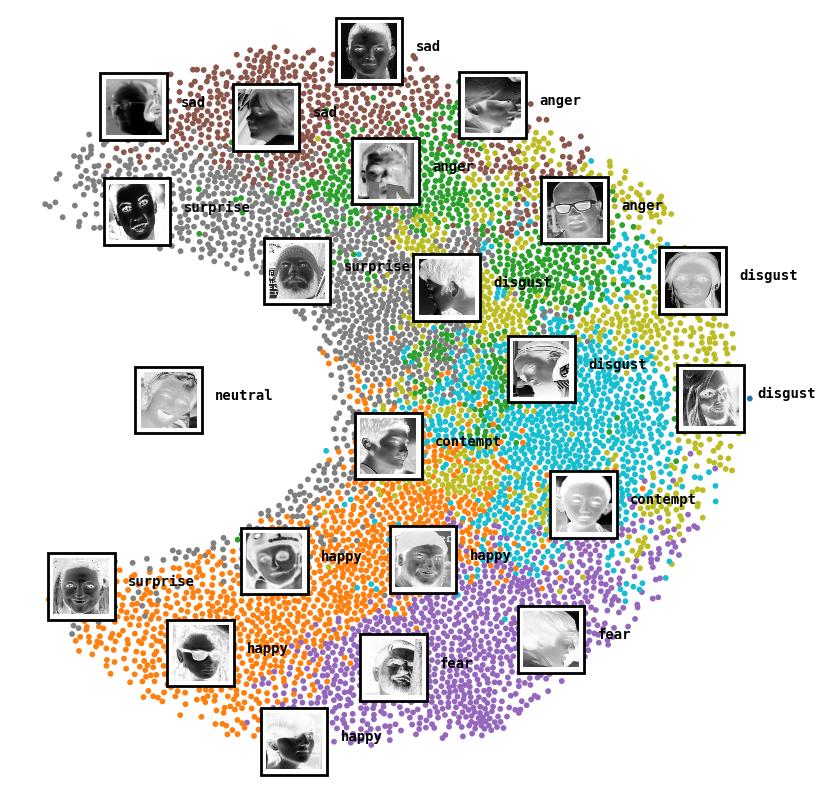

In [26]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=7)
mpl.rc('xtick', labelsize=6)
mpl.rc('ytick', labelsize=6)

plt.figure(figsize=(10, 10))
font_properties = {'family': 'monospace', 'color': 'black', 'weight': 'bold', 'size': 10}

cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c = kmeans.predict(embeddings.reshape(-1, 50*50*128)), s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(train[index], zoom=0.2, cmap="binary"),
            position, bboxprops={"lw": 2})
        plt.gca().add_artist(imagebox)
        plt.text(position[0] + 0.05, position[1], mapped_emotions[index], fontdict=font_properties)
plt.axis("off")
plt.show()

### Cropped dataset

In [3]:
train = []
files = [file for file in os.listdir(train_ds) if '.jpg' in file or '.jpeg' in file]
for file in files[:10000]:
  try:
    img = Image.open(train_ds + f"{file}").crop((25, 25, 175, 175))
    if np.asarray(img).shape == (150, 150, 3):
      train.append(np.asarray(img))
  except Exception as e:
    print(e)

In [4]:
train = np.array(train)
train.shape

(9946, 150, 150, 3)

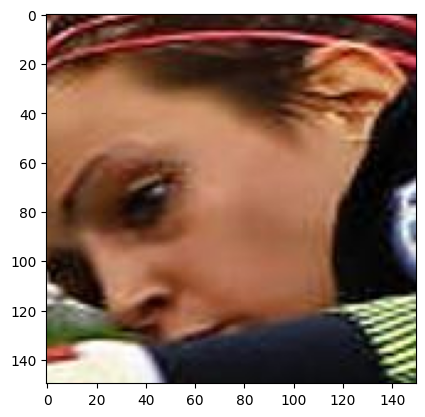

In [5]:
plt.imshow(train[0])

In [6]:
train = train.astype('float32') / 255.0

In [7]:
validation = train[int(len(train) * 0.8):]
train = train[:int(len(train) * 0.8)]

print(len(train))

7956


### Cropped training

In [8]:
tf.random.set_seed(42)
np.random.seed(42)

encoder = keras.models.Sequential([
    keras.layers.Rescaling(1.0/255, input_shape=(150, 150, 3)),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size = 1),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size = 1),
    keras.layers.Conv2D(128, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D()
])
decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="SAME", activation="selu",
                                 input_shape=[75, 75, 128]),
    keras.layers.Conv2DTranspose(64, kernel_size=3, strides=1, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=1, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=1, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=1, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(3, kernel_size=3, strides=1, padding="same", activation="sigmoid",
                        ),
    keras.layers.Reshape([150, 150, 3])
])

2023-12-05 21:23:32.316786: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78823 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2023-12-05 21:23:32.321393: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78823 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0f:00.0, compute capability: 8.0
2023-12-05 21:23:32.322936: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 78823 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:47:00.0, compute capability: 8.0
2023-12-05 21:23:32.324622: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 78823 MB memory:  -> device: 3, name: NVIDIA A100-SXM4-80GB, pci bu

In [9]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [10]:
autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(loss = 'binary_crossentropy',
                    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
                    metrics = rounded_accuracy)

In [11]:
autoencoder.fit(train, train, validation_data = [validation, validation],
                epochs = 5, batch_size = 64)

Epoch 1/5


2023-12-05 21:23:39.837032: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2023-12-05 21:23:42.533970: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55fe32d00320 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-05 21:23:42.534020: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2023-12-05 21:23:42.534025: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2023-12-05 21:23:42.534030: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2023-12-05 21:23:42.534033: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (3): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2023-12-05 21:23:42.605675: I tensorflow/compiler/mlir/tensorflow/utils/dump_

125/125 [==============================] - 33s 184ms/step - loss: 0.5682 - rounded_accuracy: 0.8823 - val_loss: 0.5431 - val_rounded_accuracy: 0.9411
Epoch 2/5
125/125 [==============================] - 13s 105ms/step - loss: 0.5365 - rounded_accuracy: 0.9534 - val_loss: 0.5367 - val_rounded_accuracy: 0.9557
Epoch 3/5
125/125 [==============================] - 13s 101ms/step - loss: 0.5334 - rounded_accuracy: 0.9598 - val_loss: 0.5358 - val_rounded_accuracy: 0.9527
Epoch 4/5
125/125 [==============================] - 13s 100ms/step - loss: 0.5321 - rounded_accuracy: 0.9633 - val_loss: 0.5338 - val_rounded_accuracy: 0.9648
Epoch 5/5
125/125 [==============================] - 13s 100ms/step - loss: 0.5316 - rounded_accuracy: 0.9646 - val_loss: 0.5333 - val_rounded_accuracy: 0.9675


In [12]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def show_reconstructions(model, images=train, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

1/1 [==============================] - 0s 350ms/step


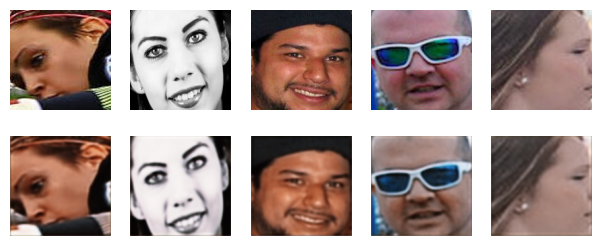

In [13]:
show_reconstructions(autoencoder)

In [14]:
embeddings = encoder.predict(train)

249/249 [==============================] - 4s 10ms/step


In [15]:
embeddings.shape

(7956, 75, 75, 128)

### Performing KMeans clustering, mapping each emotion to a cluster and visualizing using T-SNE (Cropped)

In [16]:
from sklearn.manifold import TSNE

X_valid_compressed = encoder.predict(train)
tsne = TSNE()
X_valid_compressed = X_valid_compressed.reshape(-1, 75*75*128)
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

249/249 [==============================] - 2s 8ms/step


In [17]:
emotions = {
    0:'neutral', 
    1:'happy', 
    2:'anger', 
    3:'fear', 
    4:'sad', 
    5:'surprise', 
    6:'disgust', 
    7:'contempt'
           }

emotion_labels = list(emotions.values())
emotion_clusters = emotions.keys()

kmeans = KMeans(n_clusters = len(emotion_labels)).fit(embeddings.reshape(-1, 75*75*128))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


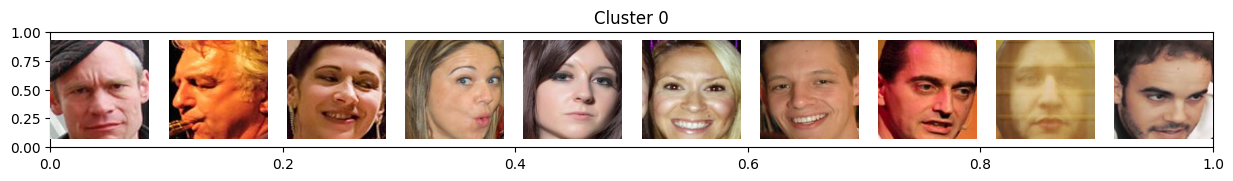

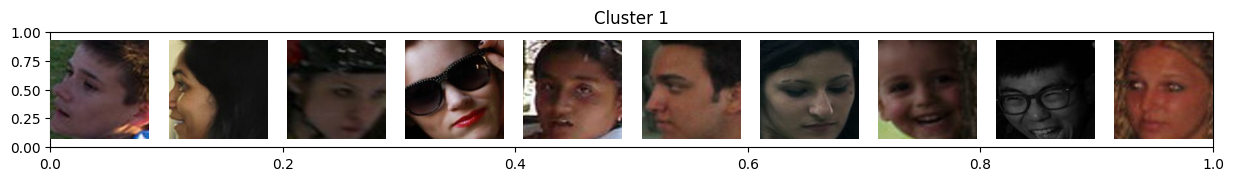

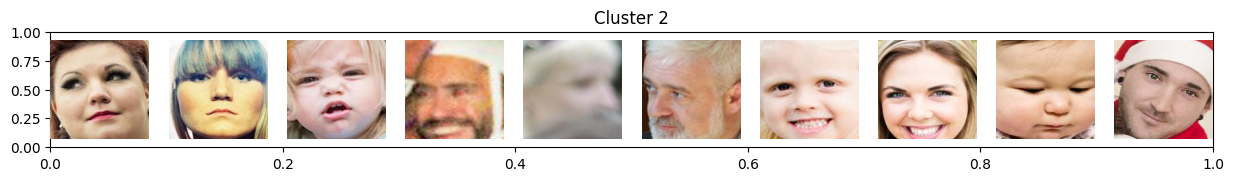

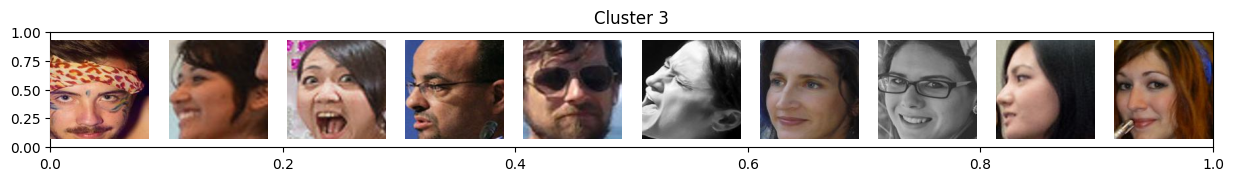

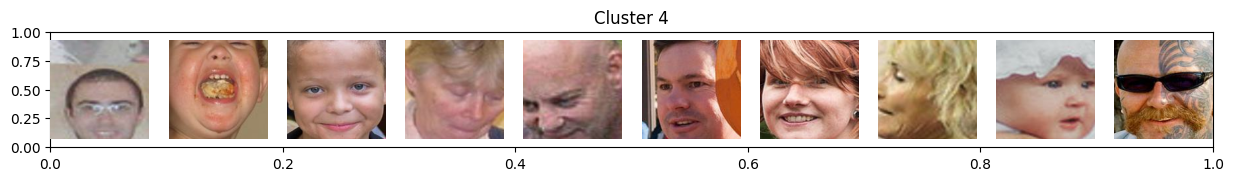

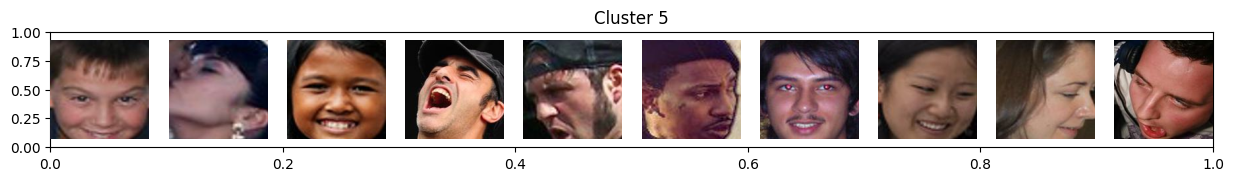

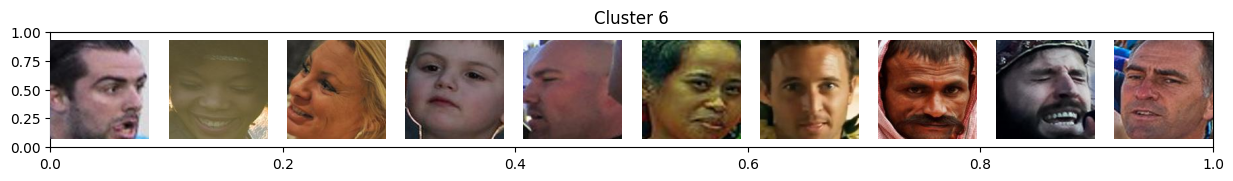

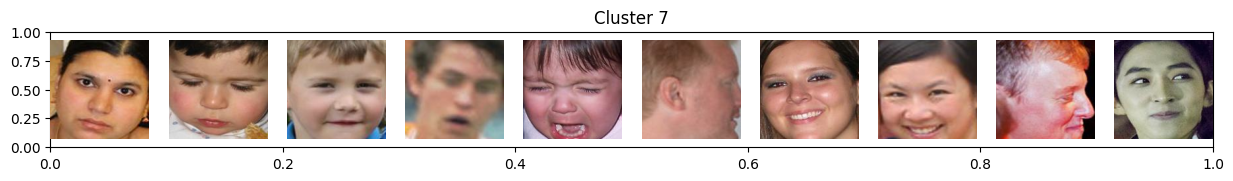

In [18]:
# Get cluster labels
cluster_labels = kmeans.labels_

# Number of clusters
num_clusters = kmeans.n_clusters

# Number of images to display per cluster
num_images_per_cluster = 10

# Iterate over each cluster
for cluster in range(num_clusters):
    # Find indices of data points in the current cluster
    cluster_indices = np.where(cluster_labels == cluster)[0]
    
    # Select 10 random indices from the current cluster (or use a different strategy to select)
    selected_indices = np.random.choice(cluster_indices, size=min(num_images_per_cluster, len(cluster_indices)), replace=False)
    
    # Display images from the current cluster
    plt.figure(figsize=(15, 1.5))
    plt.title(f'Cluster {cluster}')
    for i, index in enumerate(selected_indices):
        plt.subplot(1, num_images_per_cluster, i + 1)
        plt.imshow(train[index].reshape((150, 150, 3)))  # Assuming images are 3D, adjust if needed
        plt.axis('off')
    plt.show()

Using the images from the clusters above, assign the best aligning emotion to each cluster in the dictionary below:

In [19]:
emotions = {
    0:'contempt',
    1:'sad',
    2:'disgust',
    3:'surprise',
    4:'happy',
    5:'anger',
    6:'neutral',
    7:'fear'
}

### Load and Evaluate Emotions using AffectNet Data (Cropped)

Predicting emotion:  neutral
161/161 [==============================] - 1s 9ms/step
22.0 %
Predicting emotion:  happy
158/158 [==============================] - 1s 8ms/step
31.0 %
Predicting emotion:  anger
101/101 [==============================] - 1s 14ms/step
9.0 %
Predicting emotion:  fear
100/100 [==============================] - 1s 10ms/step
6.0 %
Predicting emotion:  sad
97/97 [==============================] - 1s 14ms/step
11.0 %
Predicting emotion:  surprise
127/127 [==============================] - 1s 9ms/step
18.0 %
Predicting emotion:  disgust
78/78 [==============================] - 1s 13ms/step
13.0 %
Predicting emotion:  contempt
90/90 [==============================] - 1s 15ms/step
23.0 %
Overall test accuracy: 0.1776737139315474


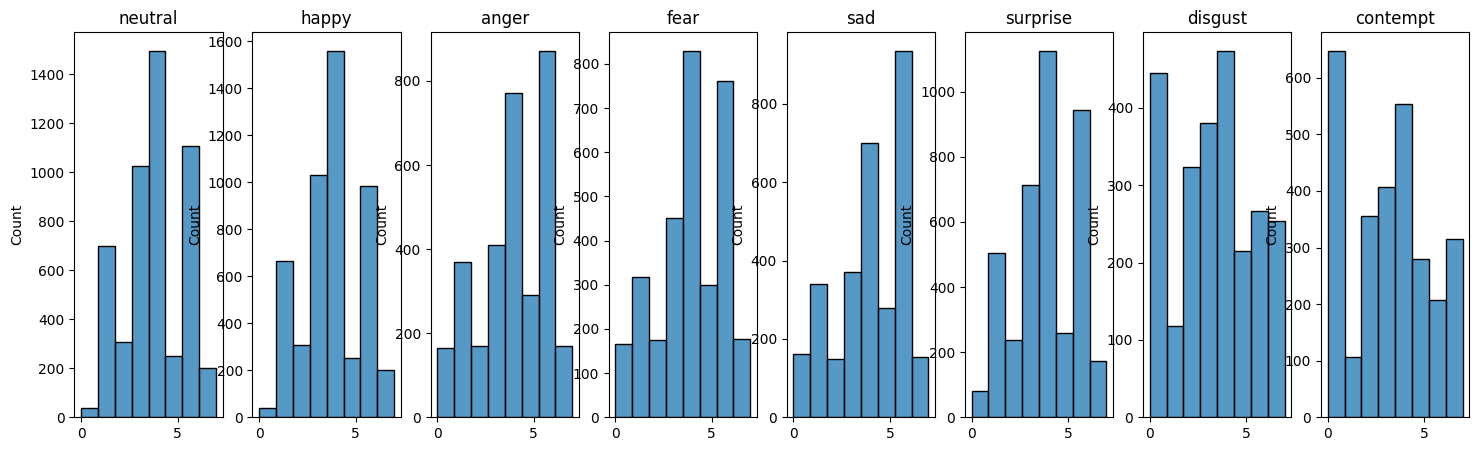

In [20]:
fig, axes = plt.subplots(1, len(emotion_labels), figsize=(18, 5))

h_index = 0

overall_correct = 0
overall_data_len = 0
for emotion in emotion_labels:
    print("Predicting emotion: ", emotion)
    test = []
    
    test_ds = 'affectnet/' + emotion + '/'
    test_files = [file for file in os.listdir(test_ds) if '.jpg' in file or '.png' in file]
    
    for file in test_files:
        try:
#             image = np.asarray((Image.open(test_ds + f"{file}")).convert('L').resize((200, 200)))
            image = np.asarray((Image.open(test_ds + f"{file}")).resize((150, 150)))
            test.append(image)
            overall_data_len += 1
        except Exception as e:
            print(e)
    
    test = np.array(test)
    test = test.astype('float32') / 255.0
    test_embeddings = encoder.predict(test)
    predictions = kmeans.predict(test_embeddings.reshape(-1, 75*75*128))
    
    sns.histplot(ax=axes[h_index], data=predictions, bins=len(emotion_labels)).set_title(emotion)
    
    correct = 0

    for key, value in emotions.items():
        if value == emotion:
            emotion_key = key
 
    for i in predictions:
        if i == emotion_key:
            correct += 1
            overall_correct += 1

    print(round(correct/len(predictions), 2)*100, '%')
    
    h_index += 1
    
print(f"Overall test accuracy: {overall_correct/overall_data_len}")

In [21]:
mapped_emotions = [emotion_labels[label] for label in kmeans.labels_]

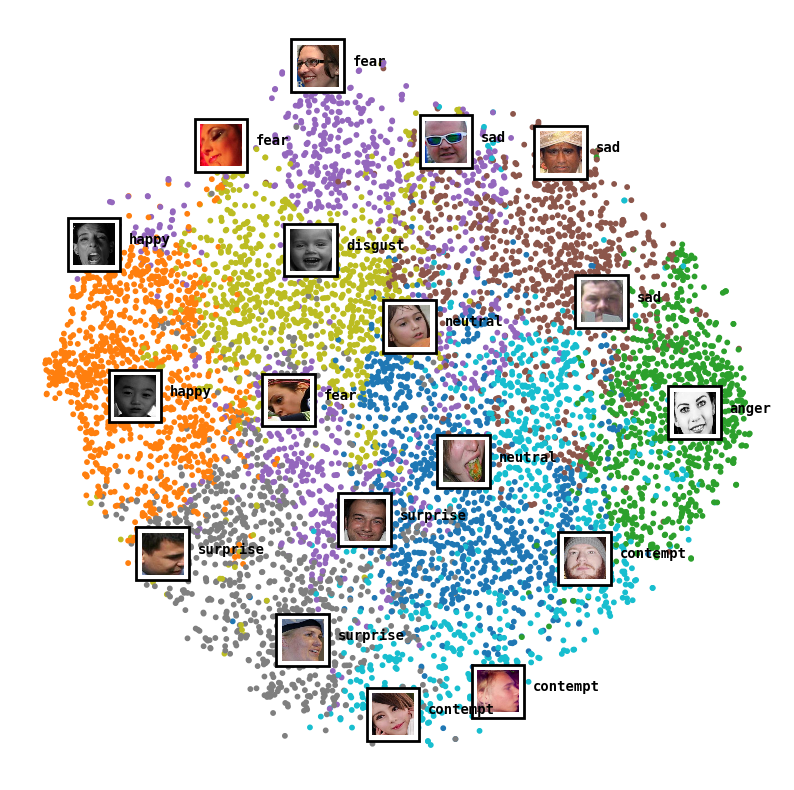

In [23]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=7)
mpl.rc('xtick', labelsize=6)
mpl.rc('ytick', labelsize=6)

plt.figure(figsize=(10, 10))
font_properties = {'family': 'monospace', 'color': 'black', 'weight': 'bold', 'size': 10}

cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c = kmeans.predict(embeddings.reshape(-1, 75*75*128)), s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(train[index], zoom=0.2, cmap="binary"),
            position, bboxprops={"lw": 2})
        plt.gca().add_artist(imagebox)
        plt.text(position[0] + 0.05, position[1], mapped_emotions[index], fontdict=font_properties)
plt.axis("off")
plt.show()